In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

читаем файл

In [61]:
url = 'https://raw.githubusercontent.com/sddanait12/data-analysis-project/refs/heads/main/heart.csv'
data = pd.read_csv(url)
print(data.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


Для начала опишем, что содержится в каждом столбце:

- **Age**: Возраст пациента (числовой признак).
- **Sex**: Пол пациента (значения: `M` (мужской), `F` (женский)).
- **ChestPainType**: Тип боли в груди ( значения: `ATA`, `NAP`, `ASY`, `TA`).
  - `ATA`: Атипичная стенокардия.
  - `NAP`: Неангинальная боль.
  - `ASY`: Бессимптомная.
  - `TA`: Типичная стенокардия.
- **RestingBP**: Артериальное давление в состоянии покоя (числовой признак).
- **Cholesterol**: Уровень холестерина (числовой признак).
- **FastingBS**: Уровень сахара в крови натощак (значения: `0` (<= 120 мг/дл), `1` (> 120 мг/дл)).
- **RestingECG**: Результаты электрокардиографии в состоянии покоя (значения: `Normal`, `ST`, `LVH`).
  - `Normal`: Норма.
  - `ST`: Наличие аномалий ST-T.
  - `LVH`: Гипертрофия левого желудочка.
- **MaxHR**: Максимальная частота сердечных сокращений (числовой признак).
- **ExerciseAngina**: Наличие стенокардии, вызванной физической нагрузкой (значения: `Y` (да), `N` (нет)).
- **Oldpeak**: Депрессия сегмента ST, вызванная физической нагрузкой (числовой признак).
- **ST_Slope**: Наклон сегмента ST при пиковой нагрузке (значения: `Up`, `Flat`, `Down`).
  - `Up`: Восходящий.
  - `Flat`: Плоский.
  - `Down`: Нисходящий.
- **HeartDisease**: Наличие сердечного заболевания (целевая переменная, бинарный признак, значения: `0` (нет), `1` (да)).

удалим дубликаты

In [62]:
data = data.drop_duplicates()

проверка на пропуски

In [63]:
print(data.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


Проверим числовые столбцы на нереалистичные значения:

для начала проверим уровень холестерина

In [64]:
zero_cholesterol = data[data['Cholesterol'] == 0]
print(zero_cholesterol[['Cholesterol']])

     Cholesterol
293            0
294            0
295            0
296            0
297            0
..           ...
514            0
515            0
518            0
535            0
536            0

[172 rows x 1 columns]


Заменим нулевые значения медианой, а не средним, так как она устойчива к выбросам

In [65]:
median_chol = data['Cholesterol'].median()
data['Cholesterol'] = data['Cholesterol'].replace(0, median_chol)

проверка строк с нулевым давлением

In [66]:
abnormal_bp = data[(data['RestingBP'] <= 0) | (data['RestingBP'] > 250)]
print(abnormal_bp[['RestingBP']])

     RestingBP
449          0


так как всего лишь одна аномальная строчка, то удалим эту строку

In [67]:
data = data[data['RestingBP'] > 0]

проверим пульс

In [68]:
abnormal_hr = data[(data['MaxHR'] < 0) | (data['MaxHR'] > 250)]
print(abnormal_hr[['MaxHR']])

Empty DataFrame
Columns: [MaxHR]
Index: []


таких строчек нет

## Создание новых признаков

1. Возрастная группа (AgeGroup)

Так как возраст — важный фактор риска сердечных заболеваний.

In [69]:
data['AgeGroup'] = pd.cut(data['Age'],  bins=[20, 40, 60, 100],  labels=['Young', 'Adult', 'Elderly'])

2. Индекс нагрузки на сердце (HeartStressIndex)

Совместим максимальный пульс и депрессию ST для оценки степени ишемической нагрузки. MaxHR показывает, как сердце реагирует на физическую нагрузку. Высокий пульс может указывать на стрессовую реакцию сердца. Oldpeak отражает ишемические изменения в сердце при нагрузке.

In [70]:
data['HeartStressIndex'] = (data['MaxHR'] * data['Oldpeak']) / 100

3. Комбинированный риск гипертонии и холестерина (HyperCholRisk).

Пациенты с высоким давлением и холестерином имеют повышенный риск сердечных заболеваний.

In [71]:
data['HyperCholRisk'] = np.where((data['RestingBP'] > 140) & (data['Cholesterol'] > 200), 1, 0)

4. Отклонение пульса от возрастной нормы (HRDeviation).


 Максимальный пульс в норме рассчитывается как $HRDeviation = MaxHR - (220 - Age) $
Отклонение от нормы может указывать на патологию.

In [72]:
data['HRDeviation'] = data['MaxHR'] - (220 - data['Age'])

5. Признак критической ишемии (CriticalIschemia)

Cильная депрессии ST (Oldpeak > 2) и нисходящий наклон ST (ST_Slope = Down).

In [73]:
data['CriticalIschemia'] = np.where((data['Oldpeak'] > 2) & (data['ST_Slope'] == 'Down'), 1, 0)

##Визуализация

1. Распределение целевой переменной (HeartDisease)


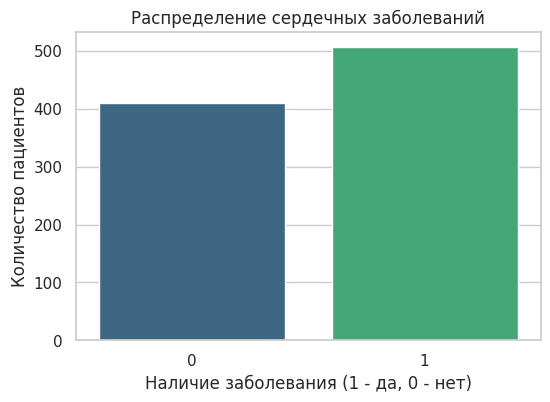

In [74]:
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=data, hue='HeartDisease', palette='viridis', legend=False)
plt.title('Распределение сердечных заболеваний')
plt.xlabel('Наличие заболевания (1 - да, 0 - нет)')
plt.ylabel('Количество пациентов')
plt.show()

2. Распределение возраста

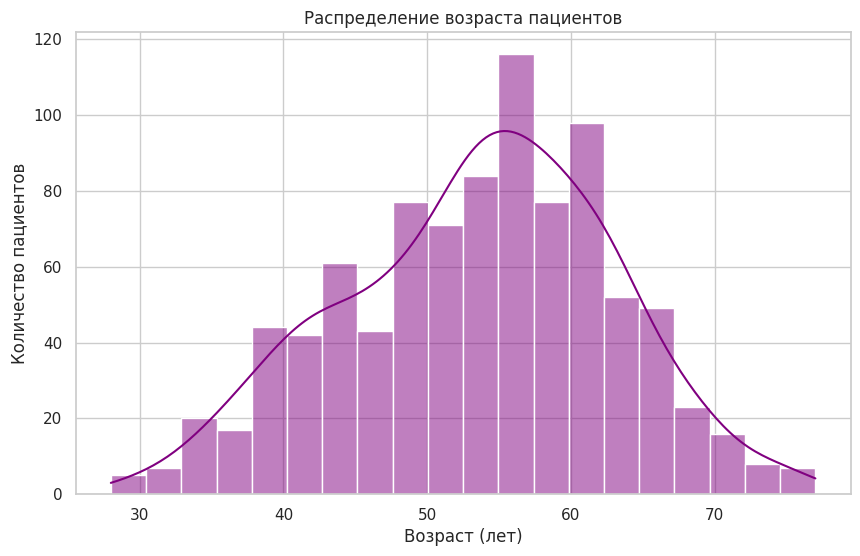

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=20, kde=True, color='purple')
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пациентов')
plt.show()

3. Взаимосвязь возраста и холестерина

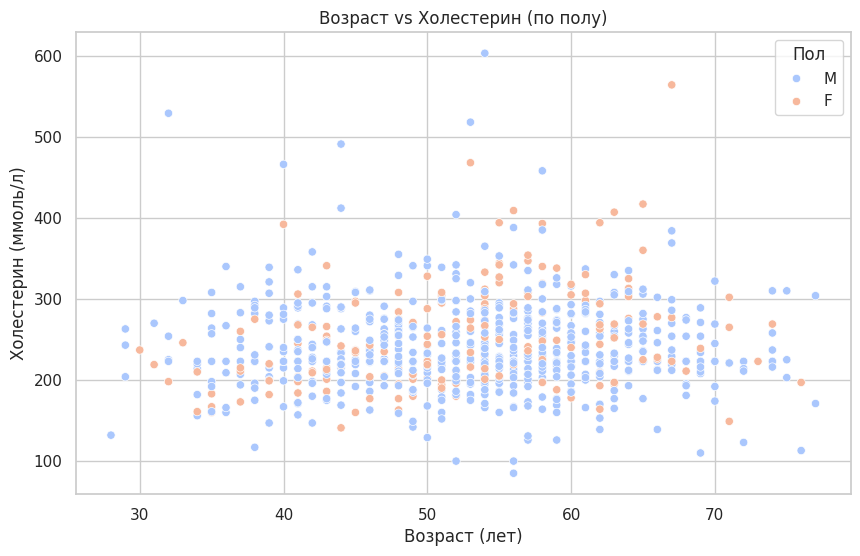

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Cholesterol', hue='Sex', data=data, palette='coolwarm')
plt.title('Возраст vs Холестерин (по полу)')
plt.xlabel('Возраст (лет)')
plt.ylabel('Холестерин (ммоль/л)')
plt.legend(title='Пол')
plt.show()

4. Распределение типов боли в груди

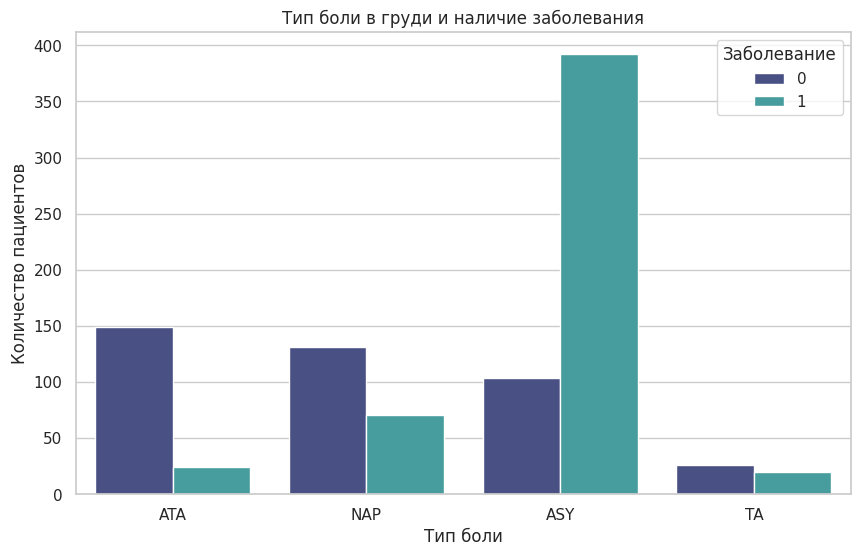

In [77]:
plt.figure(figsize=(10, 6))
sns.countplot(x='ChestPainType', hue='HeartDisease', data=data, palette='mako')
plt.title('Тип боли в груди и наличие заболевания')
plt.xlabel('Тип боли')
plt.ylabel('Количество пациентов')
plt.legend(title='Заболевание')
plt.show()

5. Корреляция числовых признаков

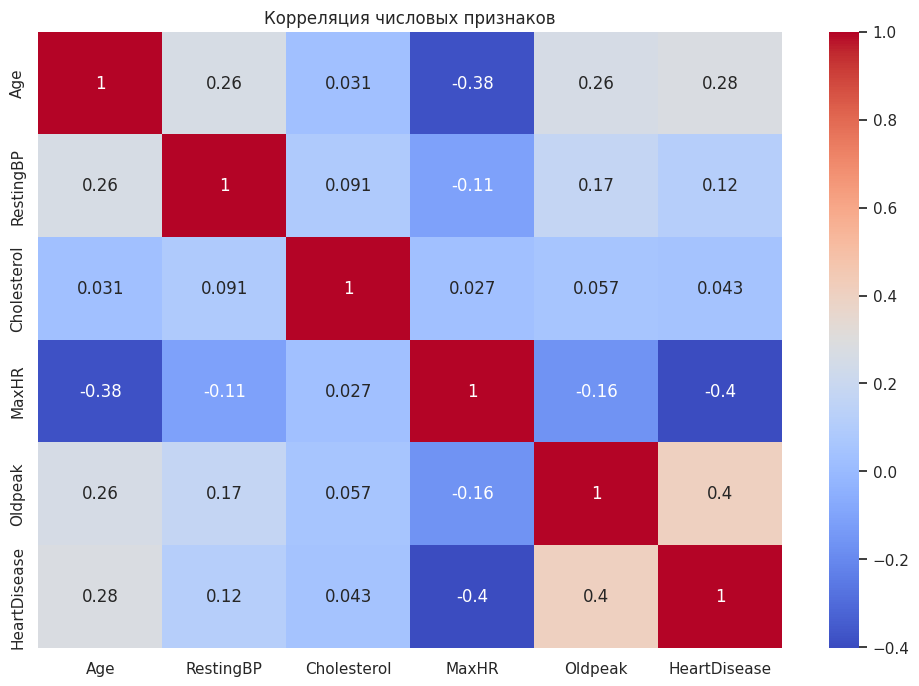

In [78]:

plt.figure(figsize=(12, 8))
corr_matrix = data[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляция числовых признаков')
plt.show()

6. Распределение пульса

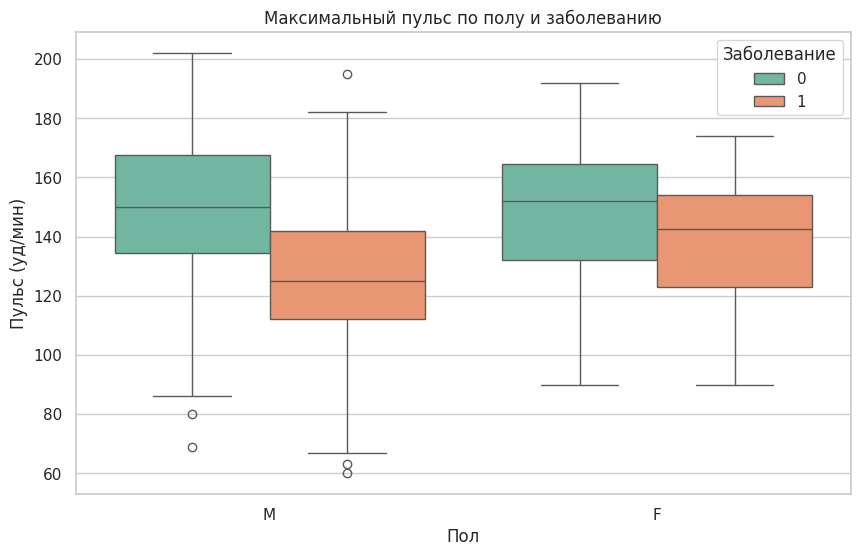

In [79]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='MaxHR', hue='HeartDisease', data=data, palette='Set2')
plt.title('Максимальный пульс по полу и заболеванию')
plt.xlabel('Пол')
plt.ylabel('Пульс (уд/мин)')
plt.legend(title='Заболевание')
plt.show()

7. Распределение уровня холестерина для пациентов с сердечными заболеваниями и без

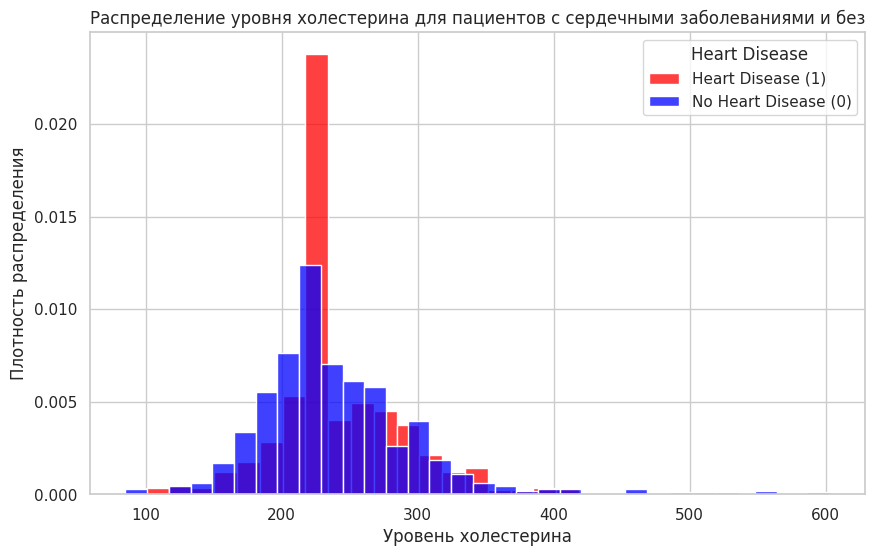

In [80]:
cholesterol_heart_disease = data[data['HeartDisease'] == 1]['Cholesterol']
cholesterol_no_heart_disease = data[data['HeartDisease'] == 0]['Cholesterol']

plt.figure(figsize=(10, 6))
sns.histplot(cholesterol_heart_disease, color="red", label="Heart Disease (1)", stat="density", bins=30)
sns.histplot(cholesterol_no_heart_disease, color="blue", label="No Heart Disease (0)", stat="density", bins=30)

plt.title("Распределение уровня холестерина для пациентов с сердечными заболеваниями и без")
plt.xlabel("Уровень холестерина")
plt.ylabel("Плотность распределения")
plt.legend(title="Heart Disease")
plt.show()

8. Распределения уровня холестерина для мужчин и женщин

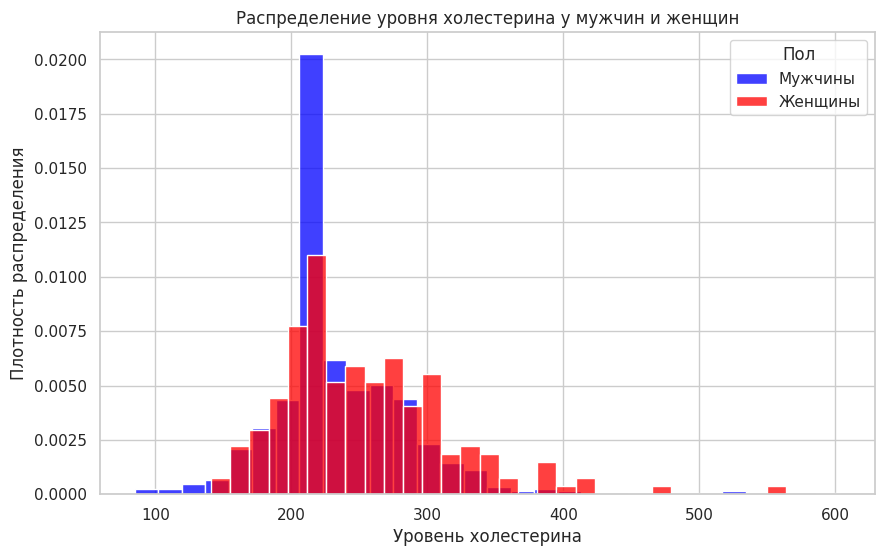

In [81]:
cholesterol_men = data[data['Sex'] == 'M']['Cholesterol']
cholesterol_women = data[data['Sex'] == 'F']['Cholesterol']

plt.figure(figsize=(10, 6))
sns.histplot(cholesterol_men, color="blue", label="Мужчины", stat="density", bins=30)
sns.histplot(cholesterol_women, color="red", label="Женщины", stat="density", bins=30)

plt.title("Распределение уровня холестерина у мужчин и женщин")
plt.xlabel("Уровень холестерина")
plt.ylabel("Плотность распределения")
plt.legend(title="Пол")
plt.show()

## Гипотезы

### 1) Уровень холестерина у пациентов с сердечными заболеваниями выше, чем у пациентов без сердечных заболеваний.



Нулевая гипотеза:

Средний уровень холестерина у пациентов с сердечными заболеваниями равен среднему уровню холестерина у пациентов без сердечных заболеваний.
$$
H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm}
$$

Альтернативная гипотеза:

Средний уровень холестеринау пациентов с сердечными заболеваниями выше, чем средний уровень холестерина у пациентов без сердечных заболеваний.

$$H_1: \hspace{2mm}  \mu_1 > \mu_2$$


Предполсылки: Объем выборки достаточно большой, дисперсия конечна

Расчитаем Z-статистику

$$ Z = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$

In [82]:
from scipy import stats

In [83]:
alpha = 0.05

cholesterol_with_disease = data[data['HeartDisease'] == 1]['Cholesterol']
cholesterol_without_disease = data[data['HeartDisease'] == 0]['Cholesterol']

n1, n2 = cholesterol_with_disease.size, cholesterol_without_disease.size

m1, m2 = cholesterol_with_disease.mean(), cholesterol_without_disease.mean()
var1, var2 = cholesterol_with_disease.var(), cholesterol_without_disease.var()

diff = m1 - m2

diff_std = np.sqrt(var1/n1 + var2/n2)

z_obs = diff / diff_std

z_crit = stats.norm.ppf(1 - alpha)

print(f'Наблюдаемое значение Z-статистики: {z_obs:.3f}')
print(f'Критическое значение Z-статистики: {z_crit:.3f}')

if z_obs > z_crit:
    print(f'{z_obs:.3f} > {z_crit:.3f} => Нулевая гипотеза отвергается')
else:
    print(f'{z_obs:.3f} <= {z_crit:.3f} => Не отвергаем нулевую гипотезу')

Наблюдаемое значение Z-статистики: 1.311
Критическое значение Z-статистики: 1.645
1.311 <= 1.645 => Не отвергаем нулевую гипотезу


### 2) Средний уровень холестерина у мужчин выше, чем у женщин

Нулевая гипотеза:

Средний уровень холестерина у мужчин равен среднему уровню холестерина у женщин.
$$
H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm}
$$

Альтернативная гипотеза:

Средний уровень холестерина у мужчин выше, чем у женщин.

$$H_1: \hspace{2mm}  \mu_1 > \mu_2$$


Предполсылки: Объем выборки достаточно большой, дисперсия конечна

Расчитаем Z-статистику

$$ Z = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$

In [85]:
alpha = 0.05

cholesterol_men = data[data['Sex'] == 'M']['Cholesterol']
cholesterol_women = data[data['Sex'] == 'F']['Cholesterol']

n1, n2 = cholesterol_men.size, cholesterol_women.size

mean1, mean2 = cholesterol_men.mean(), cholesterol_women.mean()
var1, var2 = cholesterol_men.var(), cholesterol_women.var()

diff = mean1 - mean2

diff_std = np.sqrt(var1/n1 + var2/n2)

z_obs = diff / diff_std

z_crit = stats.norm.ppf(1 - alpha)

print(f'Наблюдаемое значение Z-статистики: {z_obs:.3f}')
print(f'Критическое значение Z-статистики: {z_crit:.3f}')

if z_obs > z_crit:
    print(f'{z_obs:.3f} > {z_crit:.3f} => Нулевая гипотеза отвергается')
else:
    print(f'{z_obs:.3f} <= {z_crit:.3f} => Не отвергаем нулевую гипотезу')

Наблюдаемое значение Z-статистики: -3.497
Критическое значение Z-статистики: 1.645
-3.497 <= 1.645 => Не отвергаем нулевую гипотезу


### 3) Среди людей в возрастной группе 60-100 лет больше тех, кто имеет сердечные заболевания, чем у людей в возрастной группе 20-40 лет

Нулевая гипотеза:

Доля пациентов с сердечными заболеваниями в возрастной группе 60-100 лет равна доле пациентов с сердечными заболеваниями в возрастной группе 20-40 лет.
$$
H_0: \hspace{2mm} \mu_1 = \mu_2 \hspace{2mm}
$$

Альтернативная гипотеза:

Доля пациентов с сердечными заболеваниями в возрастной группе 60-100 лет выше, чем в возрастной группе 20-40 лет.

$$H_1: \hspace{2mm}  \mu_1 > \mu_2$$


Предполсылки: Объем выборки достаточно большой, дисперсия конечна

Расчитаем Z-статистику

$$ Z = \frac{\mu_1 - \mu_2}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$



In [86]:
alpha = 0.05

group_20_40 = data[data['AgeGroup'] == 'Young']['HeartDisease']
group_60_100 = data[data['AgeGroup'] == 'Elderly']['HeartDisease']

n1, n2 = group_60_100.size, group_20_40.size

mean1, mean2 = group_60_100.mean(), group_20_40.mean()
var1, var2 = group_60_100.var(), group_20_40.var()

diff = mean1 - mean2

diff_std = np.sqrt(var1/n1 + var2/n2)

z_obs = diff / diff_std

z_crit = stats.norm.ppf(1 - alpha)

print(f'Наблюдаемое значение Z-статистики: {z_obs:.3f}')
print(f'Критическое значение Z-статистики: {z_crit:.3f}')

if z_obs > z_crit:
    print(f'{z_obs:.3f} > {z_crit:.3f} => Нулевая гипотеза отвергается')
else:
    print(f'{z_obs:.3f} <= {z_crit:.3f} => Не отвергаем нулевую гипотезу')

Наблюдаемое значение Z-статистики: 6.640
Критическое значение Z-статистики: 1.645
6.640 > 1.645 => Нулевая гипотеза отвергается
